# MTCNN 脸部侦测(Face Detection)

## 载入相关套件

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

## 判断是否使用 GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 载入并显示图档

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

image_file = './MTCNN/angelina_jolie/1.jpg'
image = Image.open(image_file)

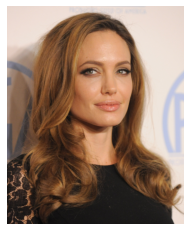

In [4]:
# 显示图像
plt.imshow(image)
plt.axis('off')
plt.show()

## 建立 MTCNN 物件，侦测脸部

In [5]:
# 建立 MTCNN 物件
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [6]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the 

## 辨识并裁切图档

In [6]:
# 辨识
image_cropped = mtcnn(image)
# 色彩通道在第一维，转换至最后一维
image_cropped = torch.permute(image_cropped, (1, 2, 0))
# 限定像素值范围介于 [0, 1]
image_cropped = image_cropped.clamp(-1, 1)
image_cropped = (image_cropped + 1) *.5  # 使像素值介于 [0, 1] 之间

## 显示图档

In [7]:
type(image_cropped)

torch.Tensor

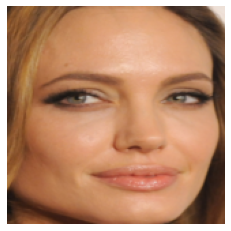

In [8]:
# 显示图像
plt.imshow(image_cropped)
plt.axis('off')
plt.show()

## 比较脸部相似性

In [63]:
# 建立 inception resnet 预先训练模型
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

## 载入资料夹下所有影像

In [71]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('./MTCNN')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn)

## 使用MTCNN识别脸部，并取得脸部向量

In [65]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print(f'脸部识别的机率: {prob:8f}')
        # 取得脸部向量
        aligned.append(x_aligned)
        # 取得姓名
        names.append(dataset.idx_to_class[y])

脸部识别的机率: 0.999983
脸部识别的机率: 0.999934
脸部识别的机率: 0.999733
脸部识别的机率: 0.999880
脸部识别的机率: 0.999992


## 转换为嵌入向量

In [66]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

## 比较嵌入向量相似性

In [69]:
# 计算夹角
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
pd.DataFrame(dists, columns=names, index=names)

,angelina_jolie,bradley_cooper,kate_siegel,paul_rudd,shea_whigham
angelina_jolie,0.000000,1.447480,0.887728,1.429847,1.399073
bradley_cooper,1.447480,0.000000,1.313749,1.013447,1.038684
kate_siegel,0.887728,1.313749,0.000000,1.388377,1.379654
paul_rudd,1.429847,1.013447,1.388377,0.000000,1.100503
shea_whigham,1.399073,1.038684,1.379654,1.100503,0.000000


# 脸部追踪

## 载入套件

In [68]:
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

## 建立 MTCNN 物件

In [70]:
mtcnn = MTCNN(keep_all=True, device=device)

## 载入视讯，并拨放视讯

In [72]:
video_path = './MTCNN/video.mp4'
video = mmcv.VideoReader(video_path)
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) 
          for frame in video]

display.Video(video_path, width=640)

## 脸部追踪

In [73]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # 脸部追踪
    boxes, _ = mtcnn.detect(frame)
    
    # 脸部画框
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # 存至 frames_tracked
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 105
Done


## 拨放脸部画框的视讯

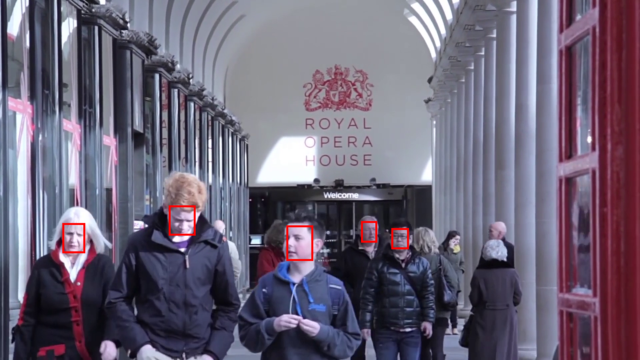

In [76]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

## 存档

In [75]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()